In [320]:
from itertools import product
from typing import NamedTuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import optuna
from optuna.integration import lightgbm as lgb
import lightgbm as lgbm
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split

from doe_modules.preferences import kwarg_savefig, outputdir

In [321]:
class Config(NamedTuple):
    savefig: bool = True
    out: str = outputdir
    suffix: str = "_test4"

conf = Config()

In [2]:
data = pd.read_feather("/home/jovyan/out/esm_test4.feather")
edges = np.array(list(map(list, product([-1, 0, 1], repeat=10))))
cloo_k, pb_k = data.cloo, data.pb

In [3]:
data

,cloo,pb,v,
0,0.600000,0.714286,2,PB
1,0.428571,0.714286,2,PB
2,0.000000,1.000000,2,PB
3,0.428571,0.750000,2,PB
4,0.428571,1.000000,2,PB
...,...,...,...,...
59044,1.000000,1.000000,3,both
59045,1.000000,0.750000,1,C+LOO
59046,0.333333,-0.333333,0,neither
59047,0.750000,0.750000,3,both


In [4]:
def n_pathways(arr) -> int:
    return np.abs(arr)[:4].sum()

def n_edges(arr) -> int:
    return np.abs(arr)[4:].sum()

def pathway_coverage(arr) -> float:
    full = arr[:4].size
    return n_pathways(arr) / full

def pathway_positivity(arr):
    n_p = n_pathways(arr)
    return (arr[:4] == 1).sum() / n_p if n_p != 0 else 0

def pathway_negativity(arr):
    n_p = n_pathways(arr)
    return (arr[:4] == -1).sum() / n_p if n_p != 0 else 0

def positive_pathway_coverage(arr):
    return (arr[:4] == 1).sum() / arr[:4].size

def negative_pathway_coverage(arr):
    return (arr[:4] == -1).sum() / arr[:4].size

def sparse_pathway_coverage(arr):
    return (arr[:4] == 0).sum() / arr[:4].size

def edge_coverage(arr) -> float:
    full = arr[4:].size
    return n_edges(arr) / full

def n_pos(arr):
    return (arr[4:] == 1).sum()

def edge_positivity(arr):
    n_e = n_edges(arr)
    return n_pos(arr) / n_e if n_e != 0 else 0

def edge_negativity(arr):
    n_e = n_edges(arr)
    return (arr[4:] == -1).sum() / n_e if n_e != 0 else 0

def positive_edge_coverage(arr):
    return (arr[4:] == 1).sum() / arr[4:].size

def negative_edge_coverage(arr):
    return (arr[4:] == -1).sum() / arr[4:].size

def sparse_edge_coverage(arr):
    return (arr[4:] == 0).sum() / arr[4:].size

def n_eff(arr): 
    return np.array([
        (arr[4] != 0) & ((arr[1] != 0) or (arr[(2, 7),] != 0).all() or (arr[(3, 8),] != 0).all() or (arr[(3, 7, 9),] != 0).all()),
        (arr[5] != 0) & ((arr[2] != 0) or (arr[(3, 9),] != 0).all()),
        (arr[6] != 0) & (arr[3] != 0),
        (arr[7] != 0) & ((arr[2] != 0) or (arr[(3, 9),] != 0).all()),
        (arr[8] != 0) & (arr[3] != 0),
        (arr[9] != 0) & (arr[3] != 0),
    ]).sum()

def edge_effectivity(arr):
    n_e = n_edges(arr)
    return n_eff(arr) / n_e if n_e != 0 else 0

def n_effpos(arr):
    return np.array([
        (arr[4] > 0) & ((arr[1] != 0) or (arr[(2, 7),] != 0).all() or (arr[(3, 8),] != 0).all() or (arr[(3, 7, 9),] != 0).all()),
        (arr[5] > 0) & ((arr[2] != 0) or (arr[(3, 9),] != 0).all()),
        (arr[6] > 0) & (arr[3] != 0),
        (arr[7] > 0) & ((arr[2] != 0) or (arr[(3, 9),] != 0).all()),
        (arr[8] > 0) & (arr[3] != 0),
        (arr[9] > 0) & (arr[3] != 0),
    ]).sum()

def n_effneg(arr):
    return np.array([
        (arr[4] < 0) & ((arr[1] != 0) or (arr[(2, 7),] != 0).all() or (arr[(3, 8),] != 0).all() or (arr[(3, 7, 9),] != 0).all()),
        (arr[5] < 0) & ((arr[2] != 0) or (arr[(3, 9),] != 0).all()),
        (arr[6] < 0) & (arr[3] != 0),
        (arr[7] < 0) & ((arr[2] != 0) or (arr[(3, 9),] != 0).all()),
        (arr[8] < 0) & (arr[3] != 0),
        (arr[9] < 0) & (arr[3] != 0),
    ]).sum()


def effective_edge_positivity(arr):
    n_e = n_eff(arr)
    return n_effpos(arr) / n_e if n_e != 0 else 0


def effective_edge_negativity(arr):
    n_e = n_eff(arr)
    return n_effneg(arr) / n_e if n_e != 0 else 0

def edge_loading(arr):
    return np.abs(arr)[:4] * np.array([
        0,
        (arr[(4),] != 0).sum(),
        (arr[(5, 7),] != 0).sum() + (arr[(4, 7),] != 0).all(),
        (arr[(6, 8, 9),] != 0).sum() + (arr[(7, 9),] != 0).all() + (arr[(5, 9),] != 0).all() + ((arr[(4, 8),] != 0).all() or (arr[(4, 7, 9),] != 0).all()),
    ])

# def max_edge_loading(arr):
#     return  edge_loading(arr).max()

# def max_edge_density(arr):
#     return max_edge_loading(arr) / n_eff(arr) if n_eff(arr) != 0 else 0

# def mean_edge_density(arr):
#     return edge_loading(arr).mean() / n_eff(arr) if n_eff(arr) != 0 else 0

def max_edge_density(arr):
    return edge_loading(arr).max() / n_eff(arr) if n_eff(arr) != 0 else 0

def mean_edge_density(arr):
    n_factor = arr[:4].size
    theoretical = n_factor * (n_factor + 1) * (n_factor - 1) / 6
    return edge_loading(arr).sum() / theoretical if theoretical != 0 else 0

def positive_edge_loading(arr):
    return (arr[:4] == 1) * np.array([
        0,
        (arr[(4),] == 1).sum(),
        (arr[(5, 7),] == 1).sum() + (arr[(4, 7),] == 1).all(),
        (arr[(6, 8, 9),] == 1).sum() + (arr[(7, 9),] == 1).all() + (arr[(5, 9),] == 1).all() + ((arr[(4, 8),] == 1).all() or (arr[(4, 7, 9),] == 1).all()),
    ])

def max_positive_edge_density(arr):
    return positive_edge_loading(arr).max() / n_eff(arr) if n_eff(arr) != 0 else 0

def mean_positive_edge_density(arr):
    n_factor = arr[:4].size
    theoretical = n_factor * (n_factor + 1) * (n_factor - 1) / 6
    return positive_edge_loading(arr).sum() / theoretical if theoretical != 0 else 0


def synergetic_edge_loading(arr):
    return np.abs(arr)[:4] * np.array([
        0,
        (arr[(4),] == 1).sum(),
        (arr[(5, 7),] == 1).sum() + (arr[(4, 7),] == 1).all(),
        (arr[(6, 8, 9),] == 1).sum() + (arr[(7, 9),] == 1).all() + (arr[(5, 9),] == 1).all() + ((arr[(4, 8),] == 1).all() or (arr[(4, 7, 9),] == 1).all()),
    ])

def max_synergetic_edge_density(arr):
    return synergetic_edge_loading(arr).max() / n_eff(arr) if n_eff(arr) != 0 else 0

def mean_synergetic_edge_density(arr):
    n_factor = arr[:4].size
    theoretical = n_factor * (n_factor + 1) * (n_factor - 1) / 6
    return synergetic_edge_loading(arr).sum() / theoretical if theoretical != 0 else 0


def factor_loading(arr):
    return np.abs(arr)[:4] * np.array([
        1,
        1 + (arr[(4),] != 0).sum(),
        1 + (arr[(7),] != 0).sum() + ((arr[(4, 7),] != 0).all() or (arr[(5),] != 0).all()),
        1 + (arr[(9),] != 0).sum() + ((arr[(7, 9),] != 0).all() or (arr[(8),] != 0).all()) + \
        ((arr[(4, 7, 9),] != 0).all() or (arr[(4, 8),] != 0).all() or (arr[(5, 9),] != 0).all() or (arr[(6),] != 0).all()),
    ])

def max_factor_density(arr):
    return factor_loading(arr).max() / len(arr[:4])

# def mean_factor_density(arr):
#     return factor_loading(arr).mean() / len(arr[:4])

def mean_factor_density(arr):
    n_factor = arr[:4].size
    theoretical = n_factor * (n_factor + 1) / 2
    return factor_loading(arr).sum() / theoretical


def positive_factor_loading(arr):
    return (arr[:4] == 1) * np.array([
        1,
        1 + (arr[(4),] == 1).sum(),
        1 + (arr[(7),] == 1).sum() + ((arr[(4, 7),] == 1).all() or (arr[(5),] == 1).all()),
        1 + (arr[(9),] == 1).sum() + ((arr[(7, 9),] == 1).all() or (arr[(8),] == 1).all()) + \
        ((arr[(4, 7, 9),] == 1).all() or (arr[(4, 8),] == 1).all() or (arr[(5, 9),] == 1).all() or (arr[(6),] == 1).all()),
    ])

def max_positive_factor_density(arr):
    return positive_factor_loading(arr).max() / len(arr[:4])


def mean_positive_factor_density(arr):
    n_factor = arr[:4].size
    theoretical = n_factor * (n_factor + 1) / 2
    return positive_factor_loading(arr).sum() / theoretical


def synergetic_factor_loading(arr):
    return np.abs(arr)[:4] * np.array([
        1,
        1 + (arr[(4),] == 1).sum(),
        1 + (arr[(7),] == 1).sum() + ((arr[(4, 7),] == 1).all() or (arr[(5),] == 1).all()),
        1 + (arr[(9),] == 1).sum() + ((arr[(7, 9),] == 1).all() or (arr[(8),] == 1).all()) + \
        ((arr[(4, 7, 9),] == 1).all() or (arr[(4, 8),] == 1).all() or (arr[(5, 9),] == 1).all() or (arr[(6),] == 1).all()),
    ])

def max_synergetic_factor_density(arr):
    return synergetic_factor_loading(arr).max() / len(arr[:4])


def mean_synergetic_factor_density(arr):
    n_factor = arr[:4].size
    theoretical = n_factor * (n_factor + 1) / 2
    return synergetic_factor_loading(arr).sum() / theoretical


def cascade_length(arr):
    return np.abs(arr)[:4] * np.array([
        1,
        1 + np.max([0, (arr[(4),] != 0).sum()]),
        1 + np.max([
            0, (arr[(5),] != 0).sum(), (arr[(7),] != 0).sum(), 
            (arr[(4, 7),] != 0).sum() * (arr[(4, 7),] != 0).all()
        ]),
        1 + np.max([
            0, (arr[(6),] != 0).sum(), (arr[(8),] != 0).sum(), (arr[(9),] != 0).sum(), 
            (arr[(4, 8),] != 0).sum() * (arr[(4, 8),] != 0).all(), 
            (arr[(5, 9),] != 0).sum() * (arr[(5, 9),] != 0).all(), 
            (arr[(7, 9),] != 0).sum() * (arr[(7, 9),] != 0).all(),
            (arr[(4, 7, 9),] != 0).sum() * (arr[(4, 7, 9),] != 0).all()
        ]),
    ])

def max_cascade_length_ratio(arr):
    return cascade_length(arr).max() / arr[:4].size

def mean_cascade_length_ratio(arr):
    n_factor = arr[:4].size
    theoretical = (1 + arr[:4].size) * arr[:4].size / 2
    return cascade_length(arr).sum() / theoretical

def positive_cascade_length(arr):
    return (arr[:4] == 1) * np.array([
        1,
        1 + np.max([0, (arr[(4),] == 1).sum()]),
        1 + np.max([
            0, (arr[(5),] == 1).sum(), (arr[(7),] == 1).sum(), 
            (arr[(4, 7),] == 1).sum() * (arr[(4, 7),] == 1).all()
        ]),
        1 + np.max([
            0, (arr[(6),] == 1).sum(), (arr[(8),] == 1).sum(), (arr[(9),] == 1).sum(),
            (arr[(4, 8),] == 1).sum() * (arr[(4, 8),] == 1).all(), 
            (arr[(5, 9),] == 1).sum() * (arr[(5, 9),] == 1).all(), 
            (arr[(7, 9),] == 1).sum() * (arr[(7, 9),] == 1).all(),
            (arr[(4, 7, 9),] == 1).sum() * (arr[(4, 7, 9),] == 1).all()
        ]),
    ])

def max_positive_cascade_length_ratio(arr):
    return positive_cascade_length(arr).max() / arr[:4].size

def mean_positive_cascade_length_ratio(arr):
    n_factor = arr[:4].size
    theoretical = (1 + arr[:4].size) * arr[:4].size / 2
    return positive_cascade_length(arr).sum() / theoretical

def synergetic_cascade_length(arr):
    return np.abs(arr)[:4] * np.array([
        1,
        1 + np.max([0, (arr[(4),] == 1).sum()]),
        1 + np.max([
            0, (arr[(5),] == 1).sum(), (arr[(7),] == 1).sum(), 
            (arr[(4, 7),] == 1).sum() * (arr[(4, 7),] == 1).all()
        ]),
        1 + np.max([
            0, (arr[(6),] == 1).sum(), (arr[(8),] == 1).sum(), (arr[(9),] == 1).sum(),
            (arr[(4, 8),] == 1).sum() * (arr[(4, 8),] == 1).all(), 
            (arr[(5, 9),] == 1).sum() * (arr[(5, 9),] == 1).all(), 
            (arr[(7, 9),] == 1).sum() * (arr[(7, 9),] == 1).all(),
            (arr[(4, 7, 9),] == 1).sum() * (arr[(4, 7, 9),] == 1).all()
        ]),
    ])

def max_synergetic_cascade_length_ratio(arr):
    return synergetic_cascade_length(arr).max() / arr[:4].size

def mean_synergetic_cascade_length_ratio(arr):
    n_factor = arr[:4].size
    theoretical = (1 + arr[:4].size) * arr[:4].size / 2
    return synergetic_cascade_length(arr).sum() / theoretical

In [5]:
df = pd.DataFrame(dict(
    pathway_coverage=list(map(pathway_coverage, edges)),
    pathway_positivity=list(map(pathway_positivity, edges)),
    pathway_negativity=list(map(pathway_negativity, edges)),
    positive_pathway_coverage=list(map(positive_pathway_coverage, edges)),
    negative_pathway_coverage=list(map(negative_pathway_coverage, edges)),
    sparse_pathway_coverage=list(map(sparse_pathway_coverage, edges)),
    edge_coverage=list(map(edge_coverage, edges)),
    edge_positivity=list(map(edge_positivity, edges)),
    edge_negativity=list(map(edge_negativity, edges)),
    positive_edge_coverage=list(map(positive_edge_coverage, edges)),
    negative_edge_coverage=list(map(negative_edge_coverage, edges)),
    sparse_edge_coverage=list(map(sparse_edge_coverage, edges)),
    edge_effectivity=list(map(edge_effectivity, edges)),
    effective_edge_positivity=list(map(effective_edge_positivity, edges)),
    effective_edge_negativity=list(map(effective_edge_negativity, edges)),
    max_edge_density=list(map(max_edge_density, edges)),
    mean_edge_density=list(map(mean_edge_density, edges)),
    max_positive_edge_density=list(map(max_positive_edge_density, edges)),
    mean_positive_edge_density=list(map(mean_positive_edge_density, edges)),
    max_synergetic_edge_density=list(map(max_synergetic_edge_density, edges)),
    mean_synergetic_edge_density=list(map(mean_synergetic_edge_density, edges)),
    max_factor_density=list(map(max_factor_density, edges)),
    mean_factor_density=list(map(mean_factor_density, edges)),
    max_positive_factor_density=list(map(max_positive_factor_density, edges)),
    mean_positive_factor_density=list(map(mean_positive_factor_density, edges)),
    max_synergetic_factor_density=list(map(max_synergetic_factor_density, edges)),
    mean_synergetic_factor_density=list(map(mean_synergetic_factor_density, edges)),
    max_cascade_length_ratio=list(map(max_cascade_length_ratio, edges)),
    mean_cascade_length_ratio=list(map(mean_cascade_length_ratio, edges)),
    max_positive_cascade_length_ratio=list(map(max_positive_cascade_length_ratio, edges)),
    mean_positive_cascade_length_ratio=list(map(mean_positive_cascade_length_ratio, edges)),
    max_synergetic_cascade_length_ratio=list(map(max_synergetic_cascade_length_ratio, edges)),
    mean_synergetic_cascade_length_ratio=list(map(mean_synergetic_cascade_length_ratio, edges)),
    # cai=list(map(cai, edges)),
    # ecai=list(map(ecai, edges)),
    # wcai=list(map(wcai, edges)),
    # wecai=list(map(wecai, edges)),
))

In [283]:
feat_names_exceptions = dict(
    sparse_pathway_coverage="pathway absence",
    sparse_edge_coverage="regulation absence",
    mean_edge_density="regulation abundance",
    mean_positive_edge_density="positive regulation abundance",
    mean_synergetic_edge_density="enhancing regulation abundance",
    mean_factor_density="regulatory factor abundance",
    mean_positive_factor_density="positive regulatory factor abundance",
    mean_synergetic_factor_density="enhancing regulatory factor abundance",
    mean_cascade_length_ratio="cascade length sufficiency",
    mean_positive_cascade_length_ratio="positive cascade length sufficiency",
    mean_synergetic_cascade_length_ratio="enhancing cascade length sufficiency",
)

feat_names_print = {
    v: feat_names_exceptions[v] if v in feat_names_exceptions else v.replace(
        "edge", "regulation").replace(
        "synergetic", "enhancing").replace(
        "factor", "regularoty factor").replace(
        "ratio", "scale"
    ).replace("_", " ") for v in df.columns
}

feat_names_short = dict(
    pathway_coverage=r"P%",
    pathway_positivity=r"P$_+$/P",
    pathway_negativity=r"P$_-$/P",
    positive_pathway_coverage=r"P$_+$%",
    negative_pathway_coverage=r"P$_-$%",
    sparse_pathway_coverage=r"P$_0$%",
    edge_coverage=r"R%",
    edge_positivity=r"R$_+$/R",
    edge_negativity=r"R$_-$/R",
    positive_edge_coverage=r"R$_+$%",
    negative_edge_coverage=r"R$_-$%",
    sparse_edge_coverage=r"R$_0$%",
    edge_effectivity=r"R$^*$/R",
    effective_edge_positivity=r"R$^*_+$/R$^*$",
    effective_edge_negativity=r"R$^*_-$/R$^*$",
    max_edge_density=r"MaxRD",
    mean_edge_density=r"RA",
    max_positive_edge_density=r"MaxRD$_+$",
    mean_positive_edge_density=r"RA$_+$",
    max_synergetic_edge_density=r"MaxRD$_&$",
    mean_synergetic_edge_density=r"RA$_&$",
    max_factor_density=r"MaxRFD",
    mean_factor_density=r"RF%",
    max_positive_factor_density=r"MaxRFD$_+$",
    mean_positive_factor_density=r"RF$_+$%",
    max_synergetic_factor_density=r"MaxRFD$_&$",
    mean_synergetic_factor_density=r"RF$_&$%",
    max_cascade_length_ratio=r"MaxCLS",
    mean_cascade_length_ratio=r"CL%",
    max_positive_cascade_length_ratio=r"MaxCLS$_+$",
    mean_positive_cascade_length_ratio=r"CL$_+$%",
    max_synergetic_cascade_length_ratio=r"MaxCLS$_&$",
    mean_synergetic_cascade_length_ratio=r"CL$_&$%",
)

feat_formula = dict(
    pathway_coverage=r"$\frac{|P|}{n}$",
    pathway_positivity=r"$\frac{|P_+|}{|P|}$",
    pathway_negativity=r"\frac{|P_-|}{|P|}",
    positive_pathway_coverage=r"$\frac{|P_+|}{n}$",
    negative_pathway_coverage=r"$\frac{|P_-|}{n}$",
    sparse_pathway_coverage=r"$\frac{n-|P|}{n}$",
    edge_coverage=r"$\frac{|R|}{{}_n \mathrm{C}_2}$",
    edge_positivity=r"$\frac{|R_+|}{|R|}$",
    edge_negativity=r"$\frac{|R_-|}{|R|}$",
    positive_edge_coverage=r"$\frac{|R_+|}{{}_n \mathrm{C}_2}$",
    negative_edge_coverage=r"$\frac{|R_-|}{{}_n \mathrm{C}_2}$",
    sparse_edge_coverage=r"$\frac{{}_n \mathrm{C}_2-|R|}{{}_n \mathrm{C}_2}$",
    edge_effectivity=r"$\frac{|R^*|}{|R|}$",
    effective_edge_positivity=r"$\frac{|R^*_+|}{|R^*|}$",
    effective_edge_negativity=r"$\frac{|R^*_-|}{|R^*|}$",
    max_edge_density=r"$\frac{\max RW}{|R^*|}$",
    mean_edge_density=r"$\frac{\sum RW}{\sum^n_{p=1}\sum^{p-1}_{q=0}q}$",
    max_positive_edge_density=r"$\frac{\max RW_+}{|R^*|}$",
    mean_positive_edge_density=r"$\frac{\sum RW_+}{\sum^n_{p=1}\sum^{p-1}_{q=0}q}$",
    max_synergetic_edge_density=r"$\frac{\max RW_&}{|R^*|}$",
    mean_synergetic_edge_density=r"$\frac{\sum RW_&}{\sum^n_{p=1}\sum^{p-1}_{q=0}q}$",
    max_factor_density=r"$\frac{\max RFW}{n}$",
    mean_factor_density=r"$\frac{\sum RFW}{\sum^n_{p=1}p}$",
    max_positive_factor_density=r"$\frac{\max RFW_+}{n}$",
    mean_positive_factor_density=r"$\frac{\sum RFW_+}{\sum^n_{p=1}p}$",
    max_synergetic_factor_density=r"$\frac{\max RFW_&}{n}$",
    mean_synergetic_factor_density=r"$\frac{\sum RFW_&}{\sum^n_{p=1}p}$",
    max_cascade_length_ratio=r"$\frac{\max CL}{n}$",
    mean_cascade_length_ratio=r"$\frac{\sum CL}{\sum^n_{p=1}p}$",
    max_positive_cascade_length_ratio=r"$\frac{\max CL_+}{n}$",
    mean_positive_cascade_length_ratio=r"$\frac{\sum CL_+}{\sum^n_{p=1}p}$",
    max_synergetic_cascade_length_ratio=r"$\frac{\max CL_&}{n}$",
    mean_synergetic_cascade_length_ratio=r"$\frac{\sum CL_&}{\sum^n_{p=1}p}$",
)

In [284]:
df.max(axis=0)

pathway_coverage                        1.0
pathway_positivity                      1.0
pathway_negativity                      1.0
positive_pathway_coverage               1.0
negative_pathway_coverage               1.0
sparse_pathway_coverage                 1.0
edge_coverage                           1.0
edge_positivity                         1.0
edge_negativity                         1.0
positive_edge_coverage                  1.0
negative_edge_coverage                  1.0
sparse_edge_coverage                    1.0
edge_effectivity                        1.0
effective_edge_positivity               1.0
effective_edge_negativity               1.0
max_edge_density                        1.0
mean_edge_density                       1.0
max_positive_edge_density               1.0
mean_positive_edge_density              1.0
max_synergetic_edge_density             1.0
mean_synergetic_edge_density            1.0
max_factor_density                      1.0
mean_factor_density             

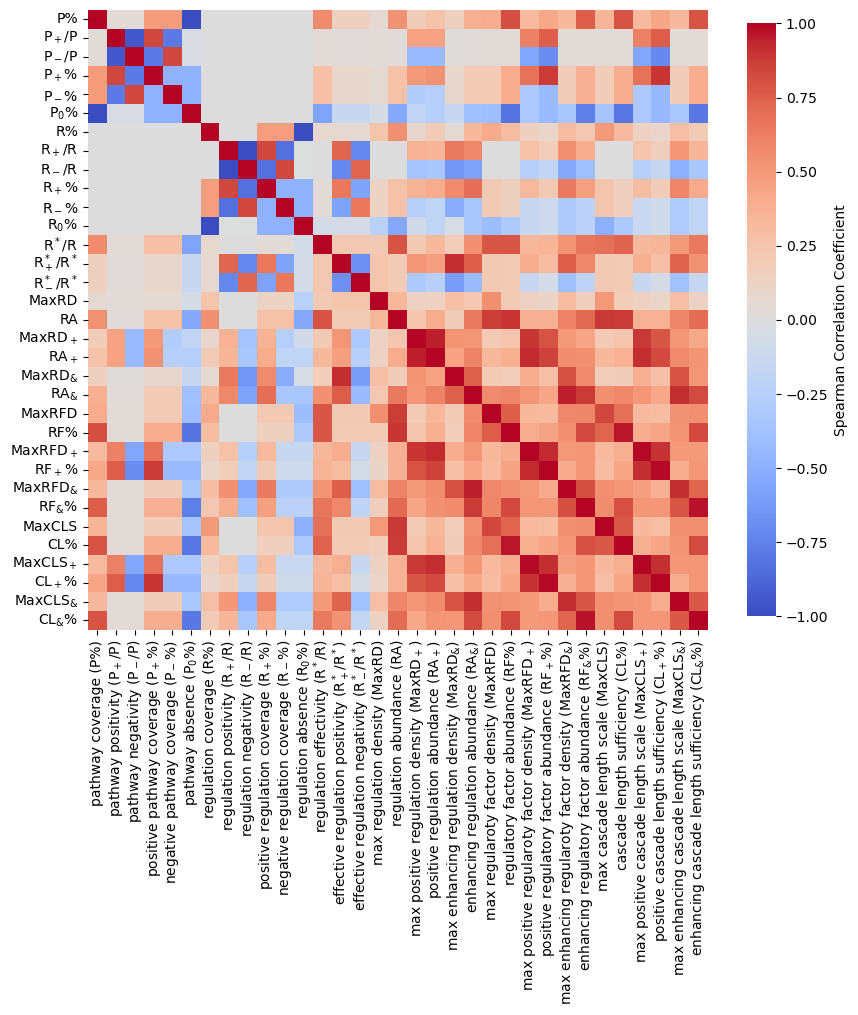

In [322]:
fig, ax = plt.subplots(figsize=(10, 11))

sns.heatmap(
    df.corr(method="spearman"), vmin=-1, vmax=1, square=True,
    cmap="coolwarm", cbar_kws={"label": "Spearman Correlation Coefficient", "shrink": .7}
)

ax.set_xticklabels([f"{feat_names_print[name]} ({feat_names_short[name]})" for name in df.columns])
ax.set_yticklabels([f"{feat_names_short[name]}" for name in df.columns]);

if conf.savefig:
    fig.savefig(f"{conf.out}/feat_corr{conf.suffix}", **kwarg_savefig)

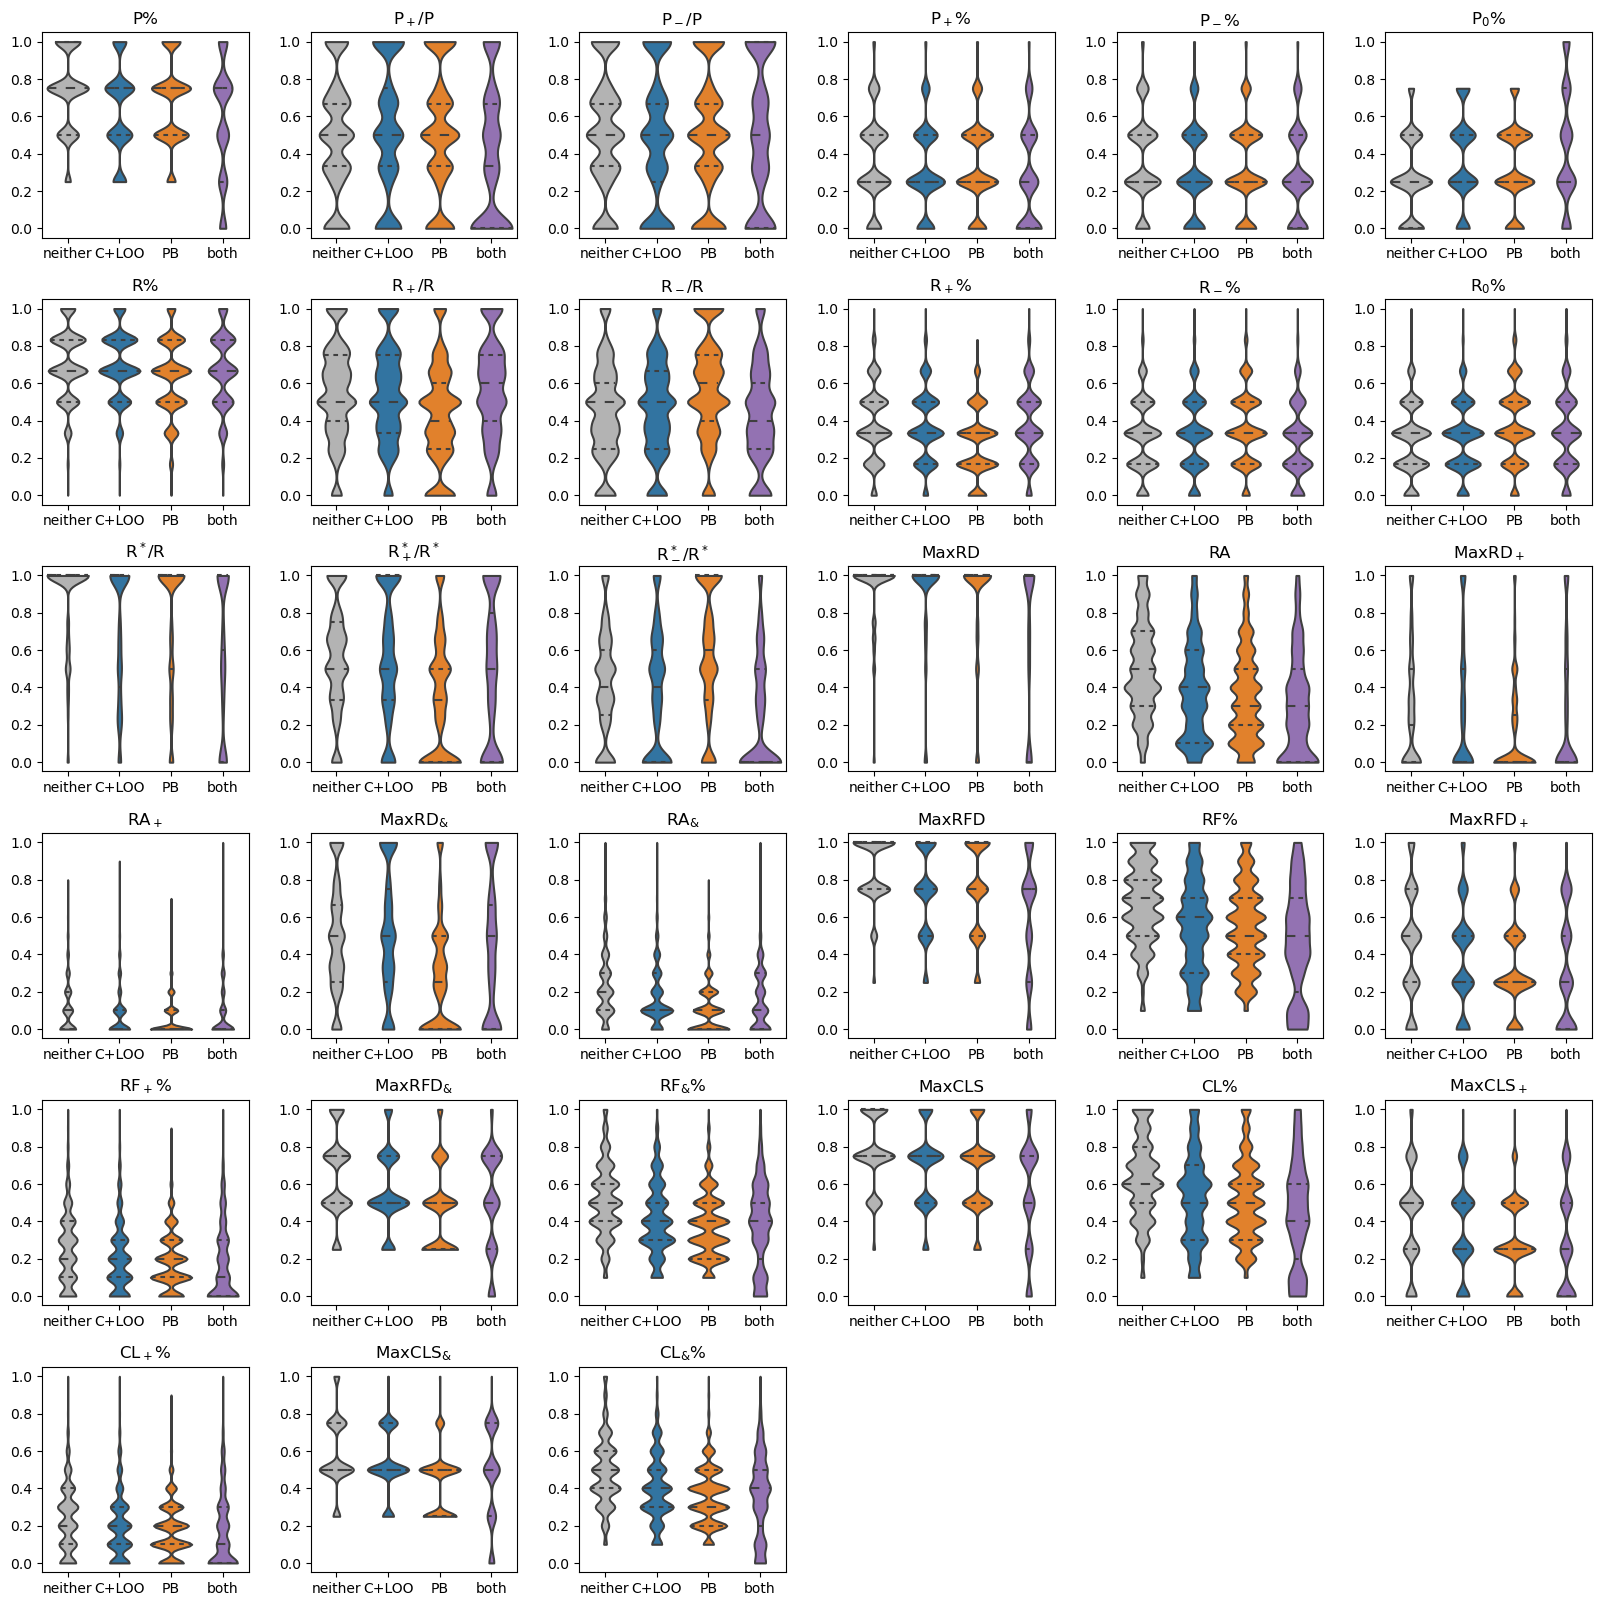

In [323]:
fig, ax = plt.subplots(6, 6, figsize=(20, 20))
plt.subplots_adjust(wspace=.3, hspace=.3)

sorted_idx = data.sort_values("v").index

for i, a in enumerate(ax.ravel()):
    if i < df.columns.size:
        sns.violinplot(
            data=df.loc[sorted_idx, :], 
            x=data.loc[sorted_idx, ""], y=df.columns[i], 
            ax=a,
            cut=0, palette=[".7", "C0", "C1", "C4"],
            inner="quart", 
            fill=False
        )
        a.set(ylabel="", title=feat_names_short[df.columns[i]])
    else:
        a.axis("off")

if conf.savefig:
    fig.savefig(f"{conf.out}/feat_violin{conf.suffix}", **kwarg_savefig)

In [41]:
from doe_modules.simulation import Test4

In [42]:
edges[80]

array([-1, -1, -1, -1, -1, -1,  1,  1,  1,  1])

In [45]:
2 + 3 * 2 + (3 ** 2) * 2 + 3 ** 3 + 3 ** 4 + (3 ** 5) * 2 + (3 ** 6) * 2 + 3 ** 7 + 3 ** 8 + 3 ** 9

30509

In [44]:
[0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, ]

[0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1]

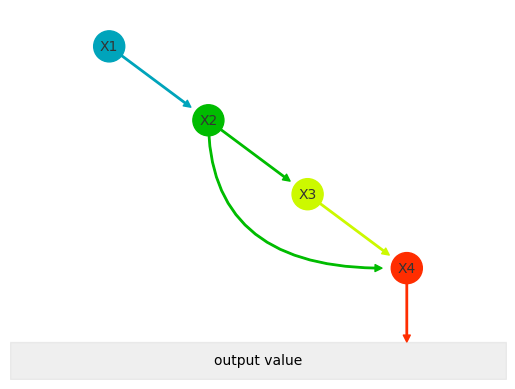

In [46]:
fig, ax = plt.subplots()

Test4(edge_assignsment=edges[30509]).plot(ax=ax)
# ax.set_title(conf.simulator(edge_assignsment=[1] * 10, model_id=3 ** 10 - 1).name)

from sklearn.manifold import TSNE

tsne = TSNE(random_state=0).fit_transform(df)

df_tsne = pd.DataFrame(tsne, columns=["x", "y"])

sns.scatterplot(
    data=df_tsne,
    x="x", y="y", hue=data.loc[:, ""]
)

In [78]:
x_tr, x_te, y_tr, y_te = train_test_split(
    df, 
    data.loc[:, "v"],
    # data.cloo,
    test_size=.2,
    random_state=0
)

x_tr, x_v, y_tr, y_v = train_test_split(
    x_tr, y_tr,
    test_size=.25,
    random_state=0
)

train = lgbm.Dataset(x_tr, y_tr)
valid = lgbm.Dataset(x_v, y_v)
test = lgbm.Dataset(x_te, y_te)


params = dict(
    objective="multiclass", 
    metric="multi_logloss",
    num_class=data.v.unique().size,
    verbosity=-1, deterministic=True,
    random_seed=0, num_boost_round=100,
    force_col_wise=True
)

# params = dict(
#     objective="regression",
#     metric="l2",
#     verbosity=-1,
#     deterministic=True,
#     random_seed=0, 
#     num_boost_round=100,
#     force_col_wise=True
# )

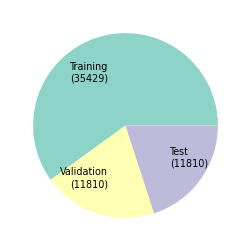

In [369]:
fig, ax = plt.subplots(figsize=(3, 3))

ax.pie(
    [y_tr.size, y_v.size, y_te.size], 
    labels=[f"{kind}\n({num})" for kind, num in zip(["Training", "Validation", "Test"],  [y_tr.size, y_v.size, y_te.size])], 
    labeldistance=.6, textprops={'size': 'x-small'},
    colors=[plt.cm.Set3(i) for i in range(3)]
)

if conf.savefig:
    fig.savefig(f"{conf.out}/holdout{conf.suffix}", **kwarg_savefig)

In [79]:
logger = {}

model = lgb.LightGBMTuner(
    params, train,
    valid_sets=valid,
    optuna_seed=0,
    # verbosity=-1,
    callbacks=[
        lgbm.early_stopping(100), 
        lgbm.log_evaluation(10000), 
        lgbm.record_evaluation(logger)
    ]
)

[I 2024-12-03 16:37:20,259] A new study created in memory with name: no-name-37d3b28c-64ef-45fb-bb0d-073c218dde68


In [80]:
%%capture
model.run()

[I 2024-12-03 16:37:21,868] Trial 0 finished with value: 0.8661550158748981 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.8661550158748981.
[I 2024-12-03 16:37:22,877] Trial 1 finished with value: 0.8685411865244483 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 0.8661550158748981.
[I 2024-12-03 16:37:23,745] Trial 2 finished with value: 0.8703881154054928 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.8661550158748981.
[I 2024-12-03 16:37:24,697] Trial 3 finished with value: 0.8656348648798132 and parameters: {'feature_fraction': 0.7}. Best is trial 3 with value: 0.8656348648798132.
[I 2024-12-03 16:37:25,614] Trial 4 finished with value: 0.8742527946788493 and parameters: {'feature_fraction': 0.4}. Best is trial 3 with value: 0.8656348648798132.
[I 2024-12-03 16:37:26,587] Trial 5 finished with value: 0.8661814742517704 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 3 with value: 0.8

In [81]:
tuned = model.get_best_booster()

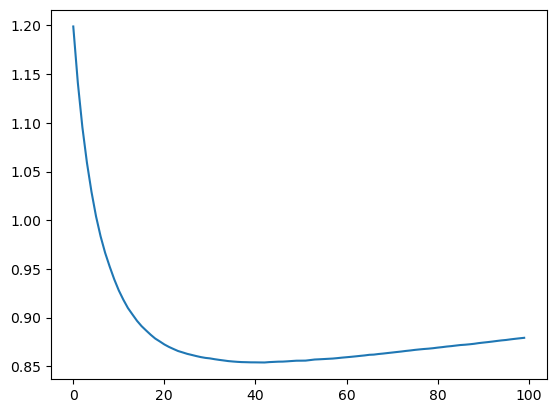

In [82]:
plt.plot(logger["valid_0"]["multi_logloss"])

In [83]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    roc_curve, roc_auc_score, 
    precision_recall_curve, 
    average_precision_score
)

In [84]:
class roc_multi():
    def __init__(self, model, x, y):
        self.x = [
            roc_curve(y[:, i], model.predict(x)[:, i])[0] for i in range(y.shape[1])
        ]
        self.y = [
            roc_curve(y[:, i], model.predict(x)[:, i])[1] for i in range(y.shape[1])
        ]
        self.thresh = [
            roc_curve(y[:, i], model.predict(x)[:, i])[2].tolist() for i in range(y.shape[1])
        ]
        self.auc = [
            roc_auc_score(y[:, i], model.predict(x)[:, i], multi_class='ovr') for i in range(y.shape[1])
        ]

In [85]:
def plot_roc(model, x, y, ax, cmap, label_dict):
    assert len(ax.ravel()) >= 4, \
        f"At least 4 subplots are required; got {ax}"
    
    roc = roc_multi(model, x, y)
    ax = ax.ravel()
    
    for (i, x_), y_, auc, label in zip(enumerate(roc.x), roc.y, roc.auc, label_dict):
        ax[i].plot(
            x_, y_, 
            label=f"{label} (AUC:{auc.round(3)})", 
            c=eval(f"plt.cm.{cmap}")(i/(len(roc.auc) - 1)) if isinstance(cmap, str) else cmap[i]
        )
    
    ax[-1].plot(
        [0] + np.linspace(0, 1, 100).tolist(), 
        [0] + np.stack([
            np.interp(np.linspace(0, 1, 100), x, y) for x, y in zip(roc.x, roc.y)
        ]).mean(axis=0).tolist(),
        c=".2",
        label=f"macro (AUC:{np.array(roc.auc).mean().round(2)})"
    )
    ax[-1].set_ylim(*ax[0].get_ylim())
    
    [sp.plot([0, 0, 1], [0, 1, 1], linestyle=(0, (1, 2)), c=".2", label="ideal", zorder=0) for sp in ax]
    [sp.plot([0, 1], [0, 1], c="gray", label="baseline", zorder=1, alpha=0.5) for sp in ax]
    [sp.set(xlabel="false positive rate", ylabel="true positive rate", title="ROC curve (OvR)") for sp in ax]
    ax[-1].set(title="ROC curve")
    [sp.legend(fontsize="small") for sp in ax]

In [86]:
class pr_multi():
    def __init__(self, model, x, y):
        self.x = [
            precision_recall_curve(y[:, i], model.predict(x)[:, i])[1] for i in range(y.shape[1])
        ]
        self.y = [
            precision_recall_curve(y[:, i], model.predict(x)[:, i])[0] for i in range(y.shape[1])
        ]
        self.thresh = [
            precision_recall_curve(y[:, i], model.predict(x)[:, i])[2].tolist() for i in range(y.shape[1])
        ]
        self.ap = [
            average_precision_score(y[:, i], model.predict(x)[:, i]) for i in range(y.shape[1])
        ]
        self.base = [len(y[:, i][y[:, i] == 1]) / len(y) for i in range(y.shape[1])]

In [87]:
def plot_pr(model, x, y, ax, cmap, label_dict):
    assert len(ax.ravel()) >= 4, \
        f"At least 4 subplots are required; got {ax}"
    
    pr = pr_multi(model, x, y)
    ax = ax.ravel()
    
    for (i, x_), y_, ap, label, base in zip(enumerate(pr.x), pr.y, pr.ap, label_dict, pr.base):
        ax[i].plot(
            x_, y_, 
            label=f"{label} (AP:{ap.round(3)})", 
            c=eval(f"plt.cm.{cmap}")(i/(len(roc.auc) - 1)) if isinstance(cmap, str) else cmap[i]
        )
        ax[i].plot([0, 1], [base, base], c="gray", label="baseline", zorder=1, alpha=0.5)
    
    p_avg, r_avg, thr_avg = precision_recall_curve(y.ravel(), model.predict(x).ravel())
    
    ax[-1].plot(
        r_avg, p_avg, 
        c=".2", 
        label=f"micro (AP:{average_precision_score(y, model.predict(x)).round(2)})"
    )
    base = np.array(pr.base).mean()
    ax[-1].plot([0, 1], [base, base], c="gray", label="baseline", zorder=1, alpha=0.5)
    ax[-1].set_ylim(*ax[0].get_ylim())
    
    [sp.plot([0, 1], [1, 1], linestyle=(0, (1, 2)), c=".2", label="ideal", zorder=2) for sp in ax]
    [sp.set(xlabel="recall", ylabel="precision", title="PR curve (OvR)") for sp in ax] 
    ax[-1].set(title="PR curve")
    [sp.legend(fontsize="small") for sp in ax]

In [301]:
testx = x_te.loc[y_te.sort_values().index, :]
testy = y_te.sort_values()

In [89]:
label_bin = label_binarize(
    testy,
    classes = testy.unique()
)

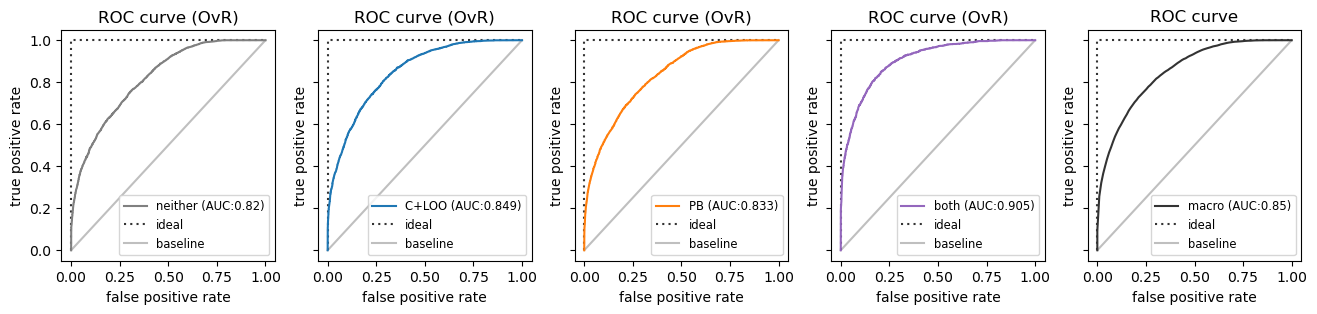

In [355]:
fig, ax = plt.subplots(1, 5, sharey=True, figsize=(16, 3))
plt.subplots_adjust(wspace=.2)

plot_roc(
    tuned, testx, label_bin, 
    ax, cmap=[".5", "C0", "C1", "C4"],
    label_dict={k: i for i, k in enumerate(["neither", "C+LOO", "PB", "both"])}
)

if conf.savefig:
    fig.savefig(f"{conf.out}/auc{conf.suffix}", **kwarg_savefig)

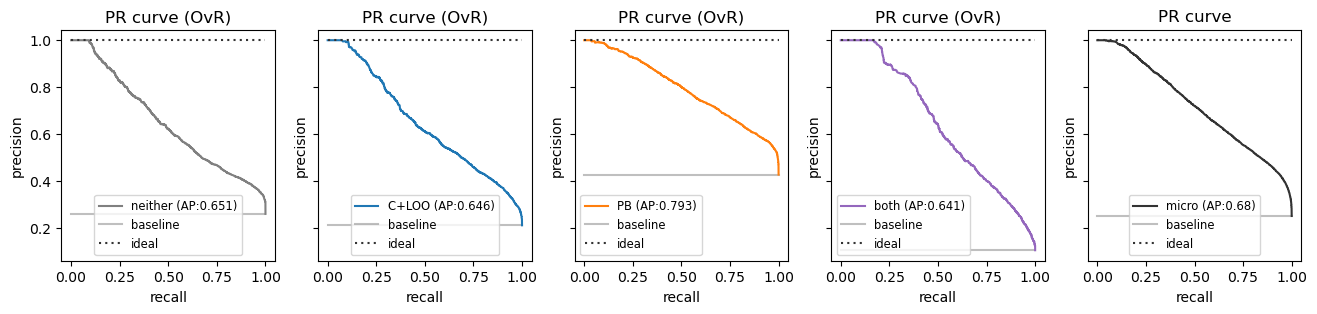

In [356]:
fig, ax = plt.subplots(1, 5, sharey=True, figsize=(16, 3))
plt.subplots_adjust(wspace=.2)

plot_pr(
    tuned, testx, label_bin, 
    ax, cmap=[".5", "C0", "C1", "C4"],
    label_dict={k: i for i, k in enumerate(["neither", "C+LOO", "PB", "both"])}
)

if conf.savefig:
    fig.savefig(f"{conf.out}/pr{conf.suffix}", **kwarg_savefig)

In [92]:
from sklearn.metrics import confusion_matrix

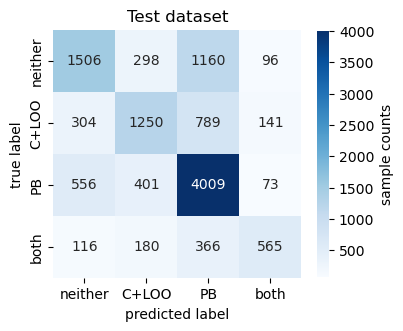

In [336]:
fig, ax = plt.subplots(figsize=(4, 4))

sns.heatmap(
    confusion_matrix(testy, tuned.predict(testx).argmax(axis=1)), 
    square=True, annot=True, fmt="", cmap="Blues",
    cbar_kws={"label": "sample counts", "shrink": .8}
)

ax.set_xticklabels(["neither", "C+LOO", "PB", "both"])
ax.set_yticklabels(["neither", "C+LOO", "PB", "both"])
ax.set(xlabel="predicted label", ylabel="true label", title="Test dataset");

if conf.savefig:
    fig.savefig(f"{conf.out}/confusion_matrix{conf.suffix}", **kwarg_savefig)

In [94]:
shap.initjs()

In [303]:
testx.columns = [feat_names_short[name] for name in df.columns]

In [304]:
explainer = shap.TreeExplainer(model=tuned)
shap_values = explainer.shap_values(X=testx)

In [354]:
for i in testy.unique():
    title = {i: k for i, k in enumerate(["neither", "C+LOO", "PB", "both"])}[i]
    plt.axes(title=title)
    shap.summary_plot(
        shap_values[:, :, i], testx, 
        # max_display=df.shape[1], 
        max_display=5,
        show=False,
        plot_size=(7, 3)
    )
    plt.savefig(f"{conf.out}/shap_{title}.png", **kwarg_savefig)
    plt.close()

In [679]:
df9 = pd.DataFrame(dict(
    pathway_coverage=[5/9, 4/9, 2/9, ],
    pathway_positivity=[4/5, 3/4, 1/2, ],
    pathway_negativity=[1/5, 1/4, 1/2, ],
    positive_pathway_coverage=[4/9, 3/9, 1/9, ],
    negative_pathway_coverage=[1/9, 1/4, 1/9, ],
    sparse_pathway_coverage=[4/9, 5/9, 7/9, ],
    edge_coverage=[6/36, 12/36, 7/36, ],
    edge_positivity=[3/6, 7/12, 4/7, ],
    edge_negativity=[3/6, 5/12, 3/7, ],
    positive_edge_coverage=[3/36, 7/36, 4/36, ],
    negative_edge_coverage=[3/36, 5/36, 3/36, ],
    sparse_edge_coverage=[30/36, 24/36, 29/36, ],
    edge_effectivity=[6/6, 11/12, 0/7, ],
    effective_edge_positivity=[3/6, 6/11, 0, ],
    effective_edge_negativity=[3/6, 5/11, 0, ],
    max_edge_density=[5/6, 10/11, 0, ],
    mean_edge_density=[(1+5+1)/(9*6), (10+11)/(9*11), 0, ],
    max_factor_density=[6/9, 6/9, 1/9, ],
    mean_factor_density=[(1+1+1+6+2)/(9*9), (1+1+5+6)/(9*9), (1+1)/(9*9)],
    max_cascade_length_ratio=[3/9, 6/9, 1/9, ],
    mean_cascade_length_ratio=[(1+1+1+3+2)/45, (1+1+5+6)/45, (1+1)/45, ],
    max_positive_cascade_length_ratio=[2/9, 5/9, 1/9],
    mean_positive_cascade_length_ratio=[(1+1+1+2)/45, (1+5+1)/45, (1)/45, ],
    max_synergetic_cascade_length_ratio=[2/9, 5/9, 1/9, ],
    mean_synergetic_cascade_length_ratio=[(1+1+1+2+2)/45, (1+1+5+1)/45, (1+1)/45, ],
    # cai=[np.mean([6/36, 3/6]), np.mean([12/36, 7/12]), np.mean([7/36, 4/7]),],
    # ecai=[np.mean([6/36, 3/6]), np.mean([11/36, 6/11]), np.mean([0/36, 0]),],
    # wcai=[np.mean([6/36, 3/6, (1+5+1)/(9*6)]), np.mean([12/36, 7/12, (10+11)/(9*11)]), np.mean([7/36, 4/7, 0]), ],
    # wecai=[np.mean([6/36, 3/6, (1+5+1)/(9*6)]), np.mean([11/36, 6/11, (10+11)/(9*11)]), np.mean([0/36, 0, 0]), ], 
))

In [521]:
tuned.predict(df9)

array([[0.01100353, 0.02952876, 0.9561488 , 0.00331891],
       [0.25099157, 0.1034319 , 0.63017613, 0.0154004 ],
       [0.01602793, 0.25946457, 0.04365106, 0.68085644]])

In [100]:
dat = pd.concat([data, df], axis=1).assign(
    max_synergetic_edge_loading=list(map(lambda arr: synergetic_edge_loading(arr).max(), edges))
).assign(
    max_cascade_length=list(map(lambda arr: cascade_length(arr).max(), edges))
).assign(
    n_effpos=list(map(n_effpos, edges)),
).assign(
    cai=(df.loc[:, "max_synergetic_edge_density"] + df.loc[:, "effective_edge_positivity"]) / 2
).assign(
    cai2=(df.loc[:, "max_synergetic_edge_density"] + 1 - df.loc[:, "mean_factor_density"]) / 2
)

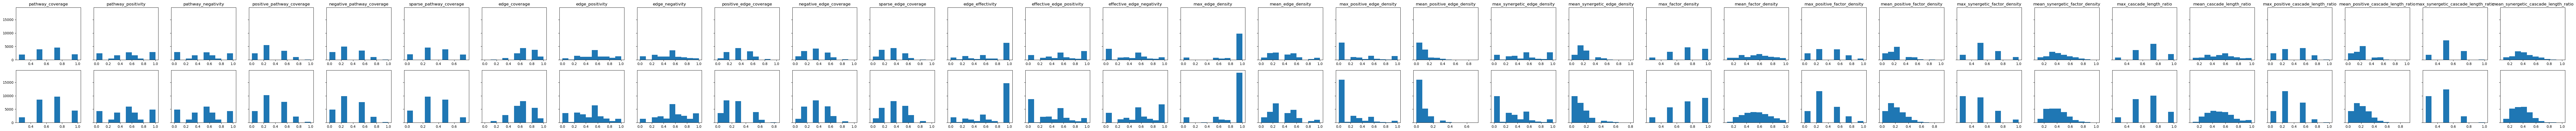

In [101]:
fig, ax = plt.subplots(2, df.columns.size, figsize=(4 * df.columns.size, 6), sharey=True)

for i, k in enumerate(df.columns):
    ax[0, i].hist(dat[dat.loc[:, ""] == "C+LOO"].loc[:, k])
    ax[1, i].hist(dat[dat.loc[:, ""] == "PB"].loc[:, k])
    ax[0, i].set_title(k)

In [102]:
def stacked_tally(df, key: str, groupby: str, stack_key: str = None, ascending: bool = True, ratio: bool = False, geq: bool = False):
    f = lambda d, b: d / d.sum() if b else d
    g = lambda d, k, v, b: d[d.loc[:, k] >= v] if b else d[d.loc[:, k] == v]
    h = lambda d, arr: pd.Series([d[name] if name in d.index else 0 for name in arr], index=arr, name=d.name)
    stack_key = stack_key if stack_key is not None else groupby
    stack_order = df.sort_values(stack_key if stack_key is not None else groupby, ascending=ascending).loc[:, groupby].unique()
    return pd.concat([
        f(
            h(g(df, key, v, geq).loc[:, groupby].value_counts(), stack_order), 
            ratio
        ).cumsum().reset_index().assign(key=v) for v in np.sort(df.loc[:, key].unique())
    ])

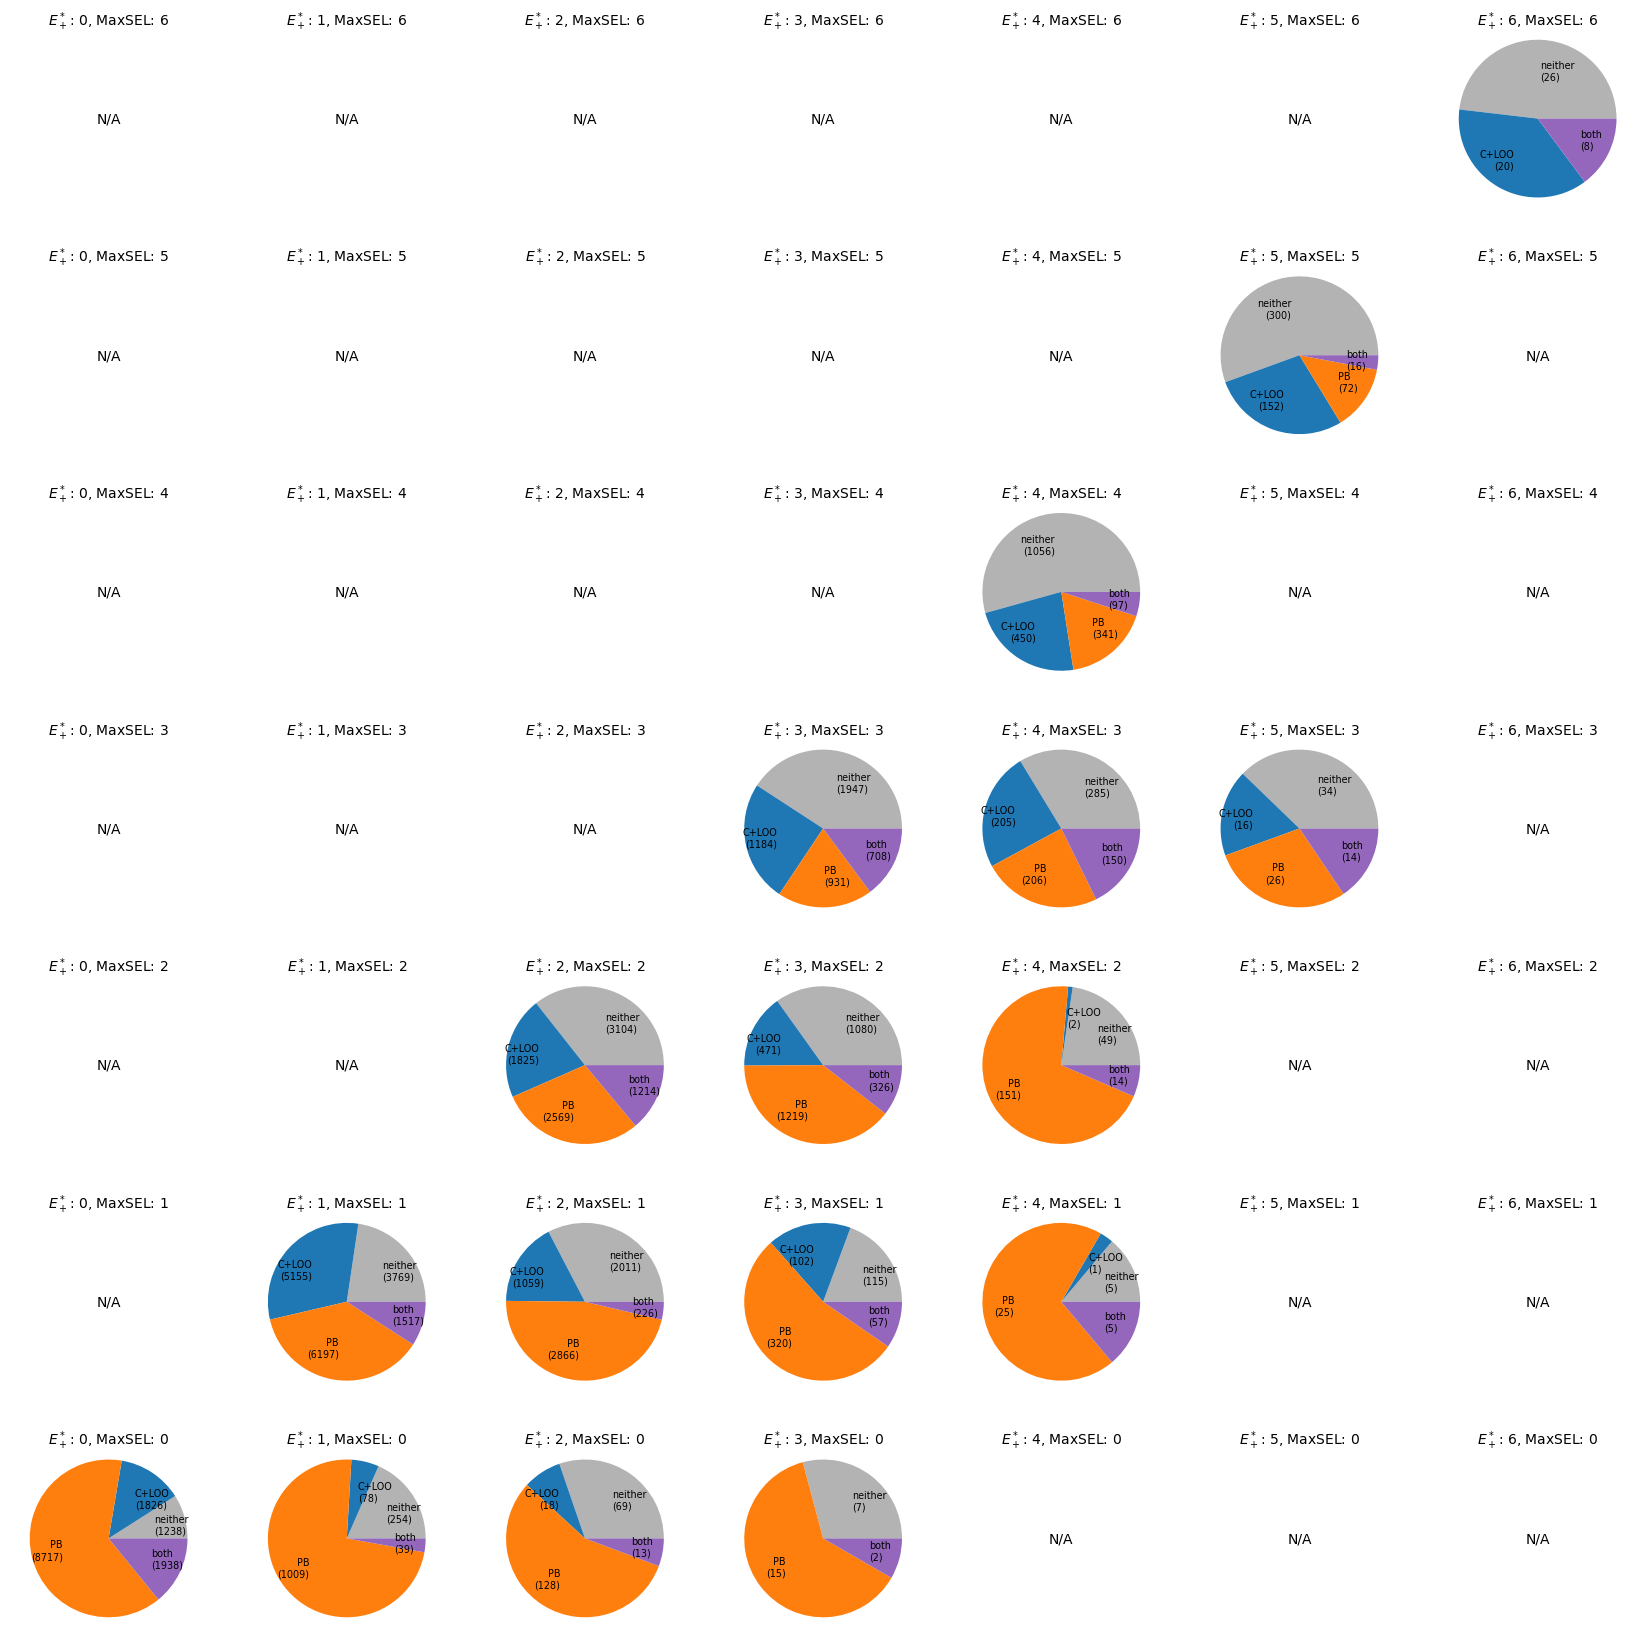

In [103]:
key_r, key_c = "max_synergetic_edge_loading", "n_effpos"
label_r, label_c = "MaxSEL", "$E_+^*$"
row, col = dat.loc[:, key_r], dat.loc[:, key_c]
nrow, ncol = row.unique().size, col.unique().size

fig, ax = plt.subplots(
    nrow, ncol,
    figsize = (3 * ncol, 3 * nrow)
)

d_label = {i: v for i, v in enumerate(["neither", "C+LOO", "PB", "both"])}
d_color = {0: ".7", 1: "C0", 2: "C1", 3: "C4"}

for i, a in enumerate(ax.ravel()):
    _d = dat[(row == nrow - 1 - i // ncol) & (col == (i % ncol))].v.value_counts().sort_index()
    a.pie(
        _d, labels=[f"{d_label[v]}\n({_d[v]})" for v in _d.index], 
        labeldistance=.6, textprops={'size': 'x-small'},
        colors=[d_color[k] for k in _d.index]
    )
    latexify = lambda name: "_{".join(name.split("_")) + "}"
    a.text(
        0, 1.1, 
        f"{label_c}: {i % ncol}, {label_r}: {nrow - 1 - i // ncol}", 
        ha="center", va="bottom"
    )
    if _d.size == 0:
        a.text(0, 0, "N/A", ha="center", va="center")
        # a.text(
        #     0, 1.1, 
        #     f"${latexify(key_c)}$: {i % ncol}, ${latexify(key_r)}$: {nrow - 1 - i // ncol}", 
        #     ha="center", va="bottom"
        # )

# if conf.savefig:
#     fig.savefig(f"{conf.out}/pie_{key_c}_{key_r}{conf.suffix}", **kwarg_savefig)

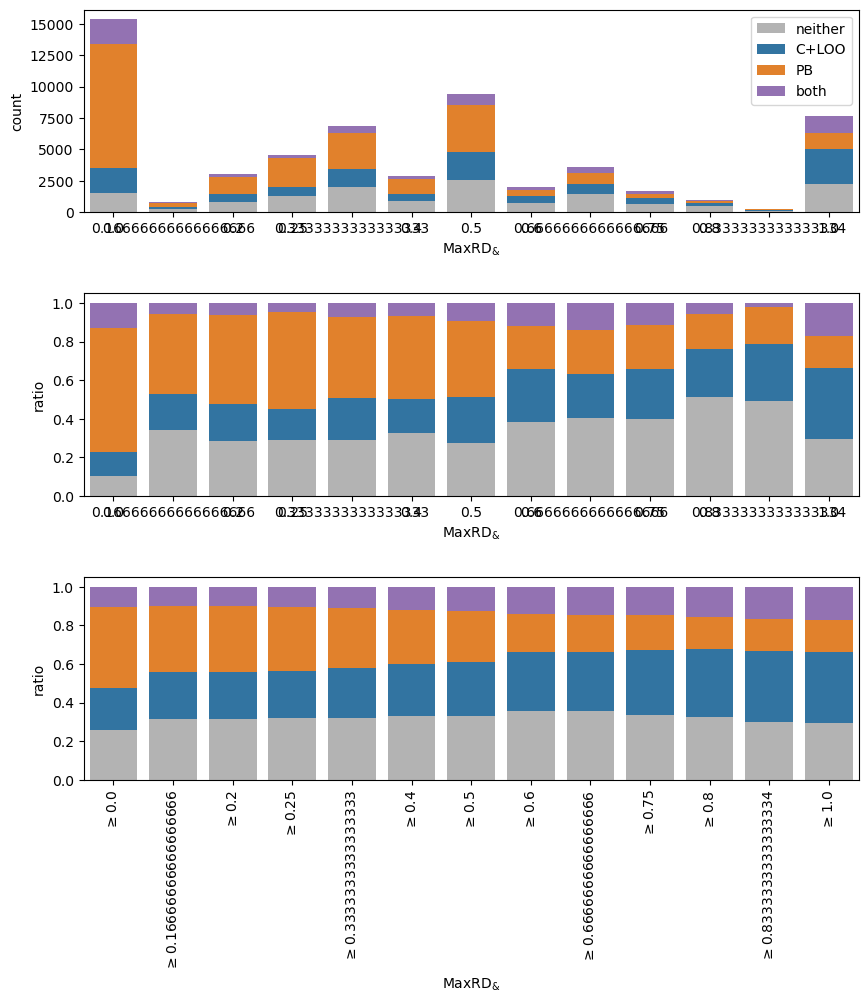

In [310]:
# key, label = "cai", "CAI"
# key, label = "cai2", "CAI2"
key = "max_synergetic_edge_density"
# key, label = "effective_edge_positivity", r"$\frac{|E^*_+|}{|E^*|}$"
# key, label = "mean_cascade_length_ratio", "MCLR"
# key, label = "max_cascade_length_ratio", "MaxCLR"
# key, label = "mean_factor_density", "MFD"

label=feat_names_short[key]

stdf = stacked_tally(dat, key, "", stack_key="v", ratio=False)
stdf2 = stacked_tally(dat, key, "", stack_key="v", ratio=True)
stdf3 = stacked_tally(dat, key, "", stack_key="v", ratio=True, geq=True)

fig, ax = plt.subplots(3, 1, figsize=(10, 10))
plt.subplots_adjust(hspace=.4)

for i, k in enumerate(stdf.loc[:, "index"].unique()):
    sns.barplot(
        data=stdf[stdf.loc[:, "index"] == k],
        x="key", y="",
        color=[".7", "C0", "C1", "C4"][i], ax=ax[0],
        zorder=-i, label=k
    )
    sns.barplot(
        data=stdf2[stdf2.loc[:, "index"] == k],
        x="key", y="",
        color=[".7", "C0", "C1", "C4"][i], ax=ax[1],
        zorder=-i, label=k
    )
    sns.barplot(
        data=stdf3[stdf3.loc[:, "index"] == k],
        x="key", y="",
        color=[".7", "C0", "C1", "C4"][i], ax=ax[2],
        zorder=-i, label=k
    )

ax[0].legend()
ax[2].set_xticklabels([r"$\geq$" + f"{v.get_text()}" for v in ax[2].get_xticklabels()])
ax[2].xaxis.set_tick_params(rotation=90)

[
    a.set(
        xlabel=label,
        ylabel=(["count"] + ["ratio"] * 2)[i]
    ) for i, a in enumerate(ax)
];

# if conf.savefig:
    # fig.savefig(f"{conf.out}/bar_n_edges_n_path{conf.suffix}", **kwarg_savefig)

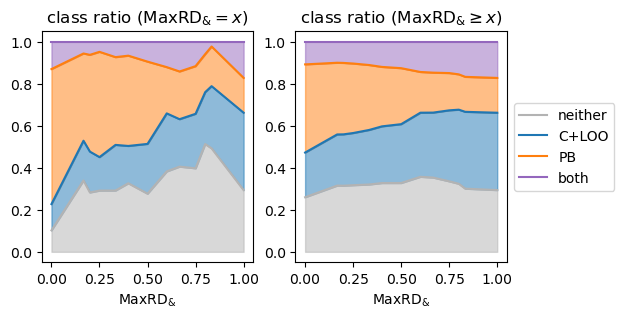

In [352]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))

for i, k in enumerate(stdf.loc[:, "index"].unique()):
    sns.lineplot(
        data=stdf2[stdf2.loc[:, "index"] == k],
        x="key", y="",
        color=[".7", "C0", "C1", "C4"][i], ax=ax[0],
        zorder=-i, label=k
    )
    sns.lineplot(
        data=stdf3[stdf3.loc[:, "index"] == k],
        x="key", y="",
        color=[".7", "C0", "C1", "C4"][i], ax=ax[1],
        zorder=-i, label=k
    )

for line_idx, line in enumerate(ax[0].lines):
    x0, y0 = line.get_xydata().T
    ax[0].fill_between(x0, 0 if line_idx == 0 else bottom, y0, color=line.get_color(), alpha=.5, zorder=-1 - line_idx)
    bottom = y0
    
for line_idx, line in enumerate(ax[1].lines):
    x1, y1 = line.get_xydata().T
    ax[1].fill_between(x1, 0 if line_idx == 0 else bottom, y1, color=line.get_color(), alpha=.5, zorder=-1 - line_idx)
    bottom = y1

# ax.set_xticklabels([r"$\geq$" + f"{round(float(v.get_text()), 3)}" for v in ax.get_xticklabels()])
# ax.xaxis.set_tick_params(rotation=90)

ax[0].get_legend().remove()
ax[1].legend(loc="center left", bbox_to_anchor=(1, .5))
ax[0].set(xlabel=label, title=f"class ratio ({label}$=x$)")
ax[1].set(xlabel=label, title=f"class ratio ({label}$\geq x$)")

if conf.savefig:
    fig.savefig(f"{conf.out}/bar_{key}{conf.suffix}", **kwarg_savefig)

[Text(0.5, 0, '$\\kappa$ values for PB designs'), Text(0, 0.5, 'CAI')]

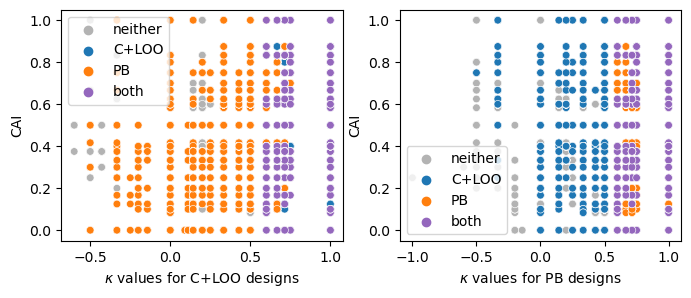

In [114]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
# plt.subplots_adjust(hspace=.3)

sns.scatterplot(
    dat.sort_values("v"), x="cloo", y="cai", 
    s=30, ax=ax[0], 
    hue="", palette=[".7", "C0", "C1", "C4"],
    # color="C0"
    # linewidth=0
)

ax[0].set(
    xlabel="$\kappa$ values for C+LOO designs", 
    ylabel="CAI"
)

sns.scatterplot(
    dat.sort_values("v"), x="pb", y="cai", 
    s=30, ax=ax[1], 
    hue="", palette=[".7", "C0", "C1", "C4"]
    # color="C1"
    # linewidth=0
)

ax[1].set(
    xlabel="$\kappa$ values for PB designs", 
    ylabel="CAI"
)


# if conf.savefig:
#     fig.savefig(f"{conf.out}/kappa_vs_cai{conf.suffix}", **kwarg_savefig)